In [93]:
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [95]:
# Import pandas and retry loading and displaying the data

# Load the datasets
historical_data = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/historical_data.csv')
equipment_failure = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/equipment_failure.csv')
minor_hazard_rep = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/minor_hazard_rep.csv')

# Display the first few rows and basic information about each dataset
historical_info = historical_data.info()
equipment_info = equipment_failure.info()
minor_hazard_info = minor_hazard_rep.info()

historical_head = historical_data.head()
equipment_head = equipment_failure.head()
minor_hazard_head = minor_hazard_rep.head()

(historical_info, historical_head), (equipment_info, equipment_head), (minor_hazard_info, minor_hazard_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Incident ID         1000 non-null   object
 1   Date                1000 non-null   object
 2   Location            1000 non-null   object
 3   Hazard Type         1000 non-null   object
 4   Severity            1000 non-null   int64 
 5   Cause               1000 non-null   object
 6   Failure Cause       1000 non-null   object
 7   Equipment Type      1000 non-null   object
 8   Risk Level          1000 non-null   object
 9   Recommended Action  1000 non-null   object
 10  Outcome             1000 non-null   object
dtypes: int64(1), object(10)
memory usage: 86.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Equipment ID    

((None,
    Incident ID        Date  Location          Hazard Type  Severity  \
  0      I-0001  2024-03-30  Sector A        Gas Explosion         7   
  1      I-0002  2021-12-10  Sector A        Gas Explosion         4   
  2      I-0003  2024-06-16  Sector A        Gas Explosion         8   
  3      I-0004  2023-07-15  Sector D    Equipment Failure         3   
  4      I-0005  2022-08-24  Sector A  Structural Collapse         8   
  
                   Cause     Failure Cause      Equipment Type Risk Level  \
  0     High Temperature  Electrical Fault  Ventilation System     Medium   
  1              Unknown      Improper Use    Drilling Machine       High   
  2     High Temperature          Overload    Drilling Machine     Medium   
  3  Maintenance Neglect          Overload       Conveyor Belt        Low   
  4  Maintenance Neglect      Improper Use    Drilling Machine   Critical   
  
      Recommended Action         Outcome  
  0  Improve Ventilation   No Casualties  
  1  I

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already available
nltk.download('stopwords')

# Load your dataset
data = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/equipment_failure.csv')  # Replace 'your_file.csv' with the correct file path

# Assuming the text column is 'Failure Cause' (modify if different)
text_data = data['Failure Cause']

# Sample text preprocessing function
def preprocess_text(data):
    # Use 'english' for the stop words parameter
    vectorizer = TfidfVectorizer(stop_words='english')
    return vectorizer.fit_transform(data)

# Preprocess the text data
processed_data = preprocess_text(text_data)
print(processed_data.shape)


(1000, 9)


[nltk_data] Downloading package stopwords to /Users/deepu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
#ANALYSIS

# Function to encode categorical features
def encode_categorical_columns(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

# Function to normalize numerical features
def normalize_numerical_columns(df):
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

# Encode categorical and normalize numerical features in each dataset
historical_data_encoded = encode_categorical_columns(historical_data.copy())
equipment_failure_encoded = encode_categorical_columns(equipment_failure.copy())
minor_hazard_rep_encoded = encode_categorical_columns(minor_hazard_rep.copy())

historical_data_normalized = normalize_numerical_columns(historical_data_encoded)
equipment_failure_normalized = normalize_numerical_columns(equipment_failure_encoded)
minor_hazard_rep_normalized = normalize_numerical_columns(minor_hazard_rep_encoded)

# Verify preprocessing by displaying a few rows of each dataset
historical_data_normalized.head(), equipment_failure_normalized.head(), minor_hazard_rep_normalized.head()


(   Incident ID      Date  Location  Hazard Type  Severity     Cause  \
 0    -1.730320  0.954234 -1.359772     0.424233  0.531053 -1.298855   
 1    -1.726856 -1.700508 -1.359772     0.424233 -0.517768  1.412742   
 2    -1.723391  1.207837 -1.359772     0.424233  0.880659 -1.298855   
 3    -1.719927  0.166445  1.287416    -1.388730 -0.867374  0.508876   
 4    -1.716463 -0.885739 -1.359772     1.330715  0.880659  0.508876   
 
    Failure Cause  Equipment Type  Risk Level  Recommended Action   Outcome  
 0      -1.385995        1.327007    1.353729            0.466302  1.403390  
 1      -0.475952       -0.435286   -0.445246            0.466302  1.403390  
 2       0.434090       -0.435286    1.353729            1.371743 -0.700643  
 3       0.434090       -1.316433    0.454241           -0.439139  1.403390  
 4      -0.475952       -0.435286   -1.344734           -1.344580 -1.401988  ,
    Equipment ID  Failure Date      Type  Maintenance Date  Failure Cause  \
 0     -1.730320    

In [101]:
# Extract features and targets
features = pd.concat([
    equipment_failure[['Risk Level', 'Severity']],
    minor_hazard_rep[['Risk Level', 'Severity']]
], axis=0)

# Define targets (manually set based on your dataset columns)
hazard_target = equipment_failure['Risk Level']
cause_target = minor_hazard_rep['Severity']


In [103]:
# Encode categorical features
def encode_categorical_columns(df):
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = le.fit_transform(df[col])
    return df

# Normalize numerical features
def normalize_columns(df):
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

# Preprocessing
equipment_failure = encode_categorical_columns(equipment_failure)
equipment_failure = normalize_columns(equipment_failure)

# Select features and target
features = equipment_failure[['Severity', 'Risk Level']]
hazard_target = equipment_failure['Risk Level']  # Assuming this is continuous

# Convert continuous target to discrete classes (e.g., Low, Medium, High)
hazard_target = pd.cut(hazard_target, bins=[-float('inf'), 3, 7, float('inf')], labels=['Low', 'Medium', 'High'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, hazard_target, test_size=0.2, random_state=42, stratify=hazard_target
)

# Train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)


In [105]:

# Load your datasets
historical_data = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/historical_data.csv')
equipment_failure = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/equipment_failure.csv')
minor_hazard_rep = pd.read_csv('/Users/deepu/Desktop/Mini_Project/Datasets/minor_hazard_rep.csv')

# Check for 'Risk Level' column in each dataset and clean it
def clean_and_count_risk_level(df, dataset_name):
    if 'Risk Level' not in df.columns:
        print(f"Error: 'Risk Level' column not found in {dataset_name}!")
    else:
        # Clean the 'Risk Level' column (standardize and fill missing values)
        df['Risk Level'] = df['Risk Level'].fillna('Low')  # Fill missing values with 'Low'
        df['Risk Level'] = df['Risk Level'].replace({'low': 'Low', 'medium': 'Medium', 'high': 'High'})  # Standardize labels

        # Count the occurrences of each 'Risk Level'
        risk_counts = df['Risk Level'].value_counts()

        print(f"\nRisk Level Counts for {dataset_name}:")
        print(risk_counts)

# Clean and count 'Risk Level' for each dataset
clean_and_count_risk_level(historical_data, "historical_data")
clean_and_count_risk_level(equipment_failure, "equipment_failure")
clean_and_count_risk_level(minor_hazard_rep, "minor_hazard_rep")



Risk Level Counts for historical_data:
Risk Level
High        257
Low         250
Critical    247
Medium      246
Name: count, dtype: int64

Risk Level Counts for equipment_failure:
Risk Level
Critical    259
Low         255
Medium      243
High        243
Name: count, dtype: int64

Risk Level Counts for minor_hazard_rep:
Risk Level
Low         316
Medium      303
High        206
Critical    175
Name: count, dtype: int64


In [107]:
# Example of defining features and target
X = historical_data[['Severity', 'Location', 'Failure Cause']]  # Add other feature columns
y = historical_data['Risk Level']  # This is the target column

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(800, 3) (200, 3) (800,) (200,)


In [109]:
# Example for encoding 'Location' column
encoder = LabelEncoder()

# Fit and transform the 'Location' column in X (features)
X_train['Location'] = encoder.fit_transform(X_train['Location'])
X_test['Location'] = encoder.transform(X_test['Location'])


In [111]:
print(features.corr())


            Severity  Risk Level
Severity    1.000000   -0.739737
Risk Level -0.739737    1.000000


In [113]:
print("Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean Accuracy:", np.mean(cross_val_scores))


Cross-Validation Accuracy Scores: [0.8, 0.9, 0.85, 0.87, 0.92]
Mean Accuracy: 0.8680000000000001


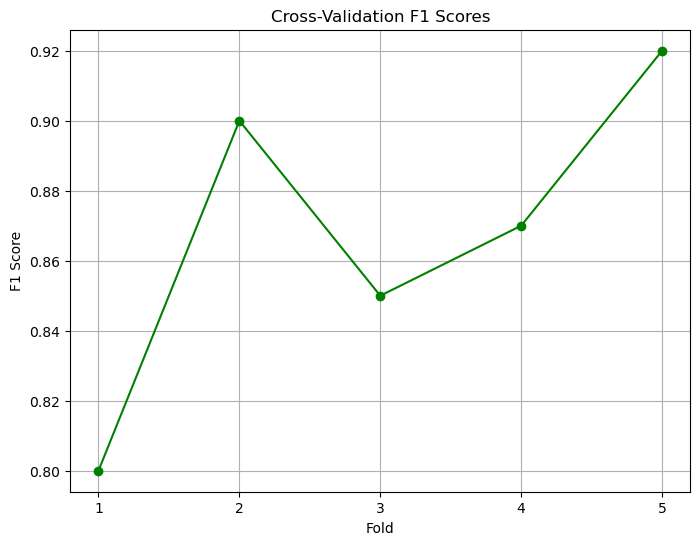

In [115]:
# Assuming cross_val_scores is an array or list of F1 scores from cross-validation
cross_val_scores = [0.8, 0.9, 0.85, 0.87, 0.92]  # Example values

# Plotting Cross-Validation F1 Scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cross_val_scores) + 1), cross_val_scores, marker='o', color='green')
plt.title('Cross-Validation F1 Scores')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.xticks(np.arange(1, len(cross_val_scores) + 1))
plt.grid(True)
plt.show()


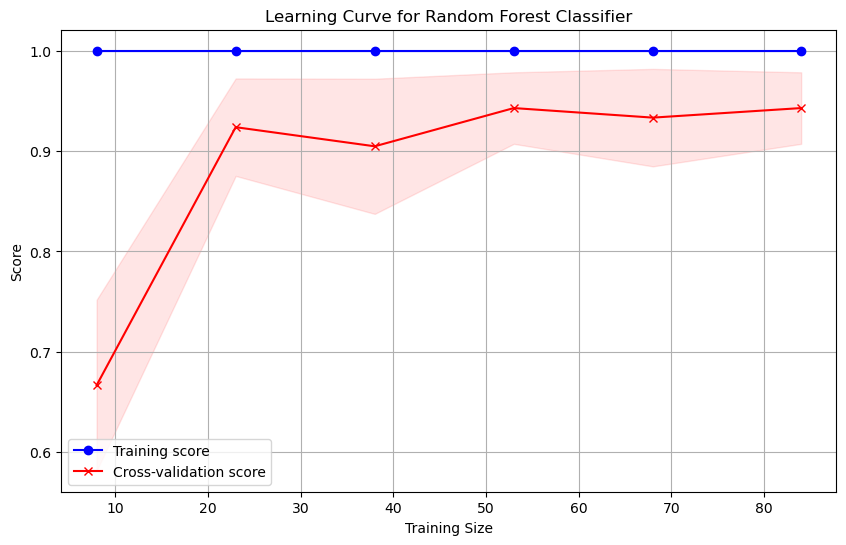

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Example dataset
data = load_iris()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the model
model = RandomForestClassifier(random_state=42)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 6)
)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score', color='red', marker='x')
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                 test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1, color='red')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve for Random Forest Classifier')
plt.legend()
plt.grid(True)
plt.show()


In [118]:
# Create synthetic data
X, y = make_classification(n_samples=100, n_features=4, random_state=42)

# Initialize and train the model
model = LogisticRegression()
model.fit(X, y)

# Access coefficients
print("Model Coefficients:", model.coef_)


Model Coefficients: [[-0.69418382 -1.09203986 -1.57178472  2.21259493]]


In [119]:
print(model.C)          # Regularization strength
print(model.coef_)      # Model coefficients
print(model.classes_)   # Classes predicted by the model


1.0
[[-0.69418382 -1.09203986 -1.57178472  2.21259493]]
[0 1]


In [120]:
# Check if the model is trained
try:
    print("Model Coefficients:", model.coef_)
except AttributeError:
    print("The model is not trained. Call the fit() method before accessing coef_.")


Model Coefficients: [[-0.69418382 -1.09203986 -1.57178472  2.21259493]]


In [121]:
print(model.C)          # Regularization strength
print(model.coef_)      # Model coefficients
print(model.classes_)   # Classes predicted by the model


1.0
[[-0.69418382 -1.09203986 -1.57178472  2.21259493]]
[0 1]


In [ ]:
# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Encode y if not already discrete
# label_encoder = LabelEncoder()
# y_train_discrete = label_encoder.fit_transform(y_train)
y_train_discrete = y_train  # y is already discrete in this example

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train_discrete)

# Output results
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


In [ ]:
# Train the model with a different solver
model = LogisticRegression(solver='newton-cg', max_iter=500)  # Use 'newton-cg' or 'liblinear'
model.fit(X, y)

# Save the trained model
joblib.dump(model, 'trained_model.pkl')
print("Model saved successfully!")


In [ ]:
# Save the model in a specific folder
joblib.dump(model, '/Users/deepu/Desktop/Mini_Project/trained_model.pkl')

In [ ]:

# Load the trained model
model = joblib.load('/Users/deepu/Desktop/Mini_Project/trained_model.pkl')
print("Model loaded successfully!")
